In [1]:
# %% [markdown]
# # Improved Landcover Classification with Enhanced Features
# Advanced feature engineering to improve forest/grassland/shrubland classification

# %%
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# %%
# Load data
train = np.load("./train.npz")
X_train = train["X"]
y_train = train["y"].reshape((-1, 1))

test = np.load("./test.npz")
X_test = test["X"]
y_test = test["y"].reshape((-1, 1))

classes = {
    1: "cultivated_land",
    2: "forest",
    3: "grassland",
    4: "shrubland",
    5: "water",
    8: "artificial_surface",
    9: "bareland",
}

y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()

# %% [markdown]
# ## Enhanced Feature Engineering
#
# To improve classification of vegetation classes (forest, grassland, shrubland), we'll extract:
# 1. **Vegetation Indices**: NDVI, EVI, SAVI for vegetation discrimination
# 2. **Spatial Features**: Texture and neighborhood statistics
# 3. **Temporal Features**: Seasonal patterns and trends
# 4. **Multi-scale Spatial Context**: Different neighborhood sizes


In [ ]:
# %%
def calculate_vegetation_indices(data):
    """
    Calculate vegetation indices assuming bands are:
    Band 0: Blue, Band 1: Green, Band 2: Red, Band 3: NIR, Band 4: SWIR1, Band 5: SWIR2
    """
    # Assuming NIR is band 3 and Red is band 2 (typical for Sentinel-2)
    red = data[:, :, :, :, 2]
    nir = data[:, :, :, :, 3]
    blue = data[:, :, :, :, 0]
    swir1 = data[:, :, :, :, 4]

    # NDVI (Normalized Difference Vegetation Index)
    ndvi = (nir - red) / (nir + red + 1e-8)

    # EVI (Enhanced Vegetation Index)
    evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1 + 1e-8)

    # SAVI (Soil Adjusted Vegetation Index) - L=0.5
    savi = 1.5 * (nir - red) / (nir + red + 0.5 + 1e-8)

    # NDWI (Normalized Difference Water Index)
    ndwi = (nir - swir1) / (nir + swir1 + 1e-8)

    return ndvi, evi, savi, ndwi


def extract_spatial_features(data, window_sizes=[3, 5]):
    """Extract spatial texture and statistical features"""
    n_samples, n_timestamps, height, width, n_bands = data.shape

    spatial_features = []

    center = height // 2

    for window_size in window_sizes:
        half_window = window_size // 2
        start_idx = center - half_window
        end_idx = center + half_window + 1

        # Extract window around central pixel
        window_data = data[:, :, start_idx:end_idx, start_idx:end_idx, :]

        # Calculate statistics
        mean_val = np.mean(
            window_data, axis=(2, 3)
        )  # (n_samples, n_timestamps, n_bands)
        std_val = np.std(window_data, axis=(2, 3))
        max_val = np.max(window_data, axis=(2, 3))
        min_val = np.min(window_data, axis=(2, 3))

        # Flatten for each window size
        spatial_features.extend(
            [
                mean_val.reshape(n_samples, -1),
                std_val.reshape(n_samples, -1),
                # max_val.reshape(n_samples, -1),
                # min_val.reshape(n_samples, -1),
            ]
        )

    return np.concatenate(spatial_features, axis=1)


def extract_temporal_features(data):
    """Extract temporal features to capture seasonal patterns"""
    n_samples, n_timestamps, height, width, n_bands = data.shape
    center = height // 2

    # Central pixel time series
    central_ts = data[:, :, center, center, :]  # (n_samples, 12, 6)

    temporal_features = []

    # For each band, calculate temporal statistics
    for band in range(n_bands):
        band_ts = central_ts[:, :, band]  # (n_samples, 12)

        # Basic temporal statistics
        temporal_mean = np.mean(band_ts, axis=1, keepdims=True)
        temporal_std = np.std(band_ts, axis=1, keepdims=True)
        temporal_max = np.max(band_ts, axis=1, keepdims=True)
        temporal_min = np.min(band_ts, axis=1, keepdims=True)
        temporal_range = temporal_max - temporal_min

        # Seasonal patterns (assuming monthly data)
        # Calculate difference between growing season (months 4-9) and dormant season
        growing_season = np.mean(band_ts[:, 3:9], axis=1, keepdims=True)
        dormant_season = np.mean(
            np.concatenate([band_ts[:, :3], band_ts[:, 9:]], axis=1),
            axis=1,
            keepdims=True,
        )
        seasonal_diff = growing_season - dormant_season

        # Trend (simple linear trend)
        time_points = np.arange(n_timestamps)
        trends = []
        for i in range(n_samples):
            slope = np.polyfit(time_points, band_ts[i], 1)[0]
            trends.append(slope)
        trends = np.array(trends).reshape(-1, 1)

        temporal_features.extend(
            [
                temporal_mean,
                temporal_std,
                temporal_max,
                temporal_min,
                temporal_range,
                seasonal_diff,
                trends,
            ]
        )

    return np.concatenate(temporal_features, axis=1)


def create_enhanced_features(X):
    """Create comprehensive feature set"""
    # 1. Central pixel features (baseline)
    central_features = X[:, :, 6, 6, :].reshape(X.shape[0], -1)

    # 2. Vegetation indices
    ndvi, evi, savi, ndwi = calculate_vegetation_indices(X)

    # Central pixel vegetation indices
    vi_features = []
    for vi in [ndvi, evi, savi, ndwi]:
        vi_central = vi[:, :, 6, 6].reshape(X.shape[0], -1)  # 12 timestamps
        vi_features.append(vi_central)

        # Add temporal statistics for each VI
        vi_mean = np.mean(vi_central, axis=1, keepdims=True)
        vi_std = np.std(vi_central, axis=1, keepdims=True)
        vi_max = np.max(vi_central, axis=1, keepdims=True)
        vi_min = np.min(vi_central, axis=1, keepdims=True)
        vi_features.extend([vi_mean, vi_std, vi_max, vi_min])

    vi_features = np.concatenate(vi_features, axis=1)

    # 3. Spatial features
    spatial_features = extract_spatial_features(X, window_sizes=[5])

    # 4. Temporal features
    temporal_features = extract_temporal_features(X)

    # Combine all features
    all_features = np.concatenate(
        [
            central_features,  # 72 features
            # vi_features,  # 4*12 + 4*4*4 = 112 features
            spatial_features,  # Variable
            # temporal_features,  # 6*7 = 42 features
        ],
        axis=1,
    )

    return all_features


In [4]:
print("Creating enhanced features...")
X_train_enhanced = create_enhanced_features(X_train)
X_test_enhanced = create_enhanced_features(X_test)

print("Original central pixel features: 72")
print(f"Enhanced features: {X_train_enhanced.shape[1]}")
print(f"Feature expansion ratio: {X_train_enhanced.shape[1] / 72:.1f}x")

# %% [markdown]
# ## Improved Model with Class Balancing and Feature Scaling

# %%
# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train_flat), y=y_train_flat
)
class_weight_dict = dict(zip(np.unique(y_train_flat), class_weights))

print("Class weights for balancing:")
for class_id, weight in class_weight_dict.items():
    print(f"  {classes[class_id]}: {weight:.3f}")

# %% [markdown]
# ## Model Comparison: AdaBoost vs Random Forest


# %%
# Create pipeline with scaling
def create_pipeline(classifier):
    return Pipeline([("scaler", StandardScaler()), ("classifier", classifier)])


# Define multiple models to compare
models = {
    "AdaBoost_Enhanced": create_pipeline(
        AdaBoostClassifier(
            estimator=DecisionTreeClassifier(criterion="gini", random_state=42),
            # algorithm="SAMME",
            random_state=42,
        )
    ),
    # 'RandomForest': create_pipeline(RandomForestClassifier(
    #     criterion='gini',
    #     class_weight='balanced',
    #     random_state=42
    # )),
    # "AdaBoost_Balanced": create_pipeline(
    #     AdaBoostClassifier(
    #         estimator=DecisionTreeClassifier(
    #             criterion="gini", class_weight="balanced", random_state=42
    #         ),
    #         algorithm="SAMME",
    #         random_state=42,
    #     )
    # ),
}

# Define parameter grids
param_grids = {
    "AdaBoost_Enhanced": {
        "classifier__estimator__max_depth": [1, 2, 3],
        "classifier__n_estimators": [50, 100, 200],
    },
    # 'RandomForest': {
    #     'classifier__max_depth': [5, 10, 15, None],
    #     'classifier__n_estimators': [100, 200],
    #     'classifier__min_samples_split': [2, 5]
    # },
    # "AdaBoost_Balanced": {
    #     "classifier__estimator__max_depth": [2, 3, 4],
    #     "classifier__n_estimators": [100, 200, 300],
    # },
}

# Cross-validation setup
cv = StratifiedKFold(
    n_splits=2, shuffle=True, random_state=42
)  # Using 3-fold for more robust CV

results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0,
    )

    grid_search.fit(X_train_enhanced, y_train_flat)

    # Store results
    results[model_name] = {
        "best_model": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "test_pred": grid_search.best_estimator_.predict(X_test_enhanced),
        "test_accuracy": accuracy_score(
            y_test_flat, grid_search.best_estimator_.predict(X_test_enhanced)
        ),
    }

    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
    print(f"Test accuracy: {results[model_name]['test_accuracy']:.4f}")
    print(f"Best parameters: {grid_search.best_params_}")


Creating enhanced features...
Original central pixel features: 72
Enhanced features: 216
Feature expansion ratio: 3.0x
Class weights for balancing:
  cultivated_land: 5.120
  forest: 0.214
  grassland: 1.102
  shrubland: 1.610
  water: 22.073
  artificial_surface: 5.676
  bareland: 2.614

Training AdaBoost_Enhanced...
Best CV accuracy: 0.7495
Test accuracy: 0.7602
Best parameters: {'classifier__estimator__max_depth': 3, 'classifier__n_estimators': 200}



MODEL COMPARISON RESULTS
AdaBoost_Enhanced   : 0.7602 ★ BEST

Best model: AdaBoost_Enhanced
Test accuracy improvement: 0.7602 vs 0.7188 baseline
Improvement: +4.14 percentage points


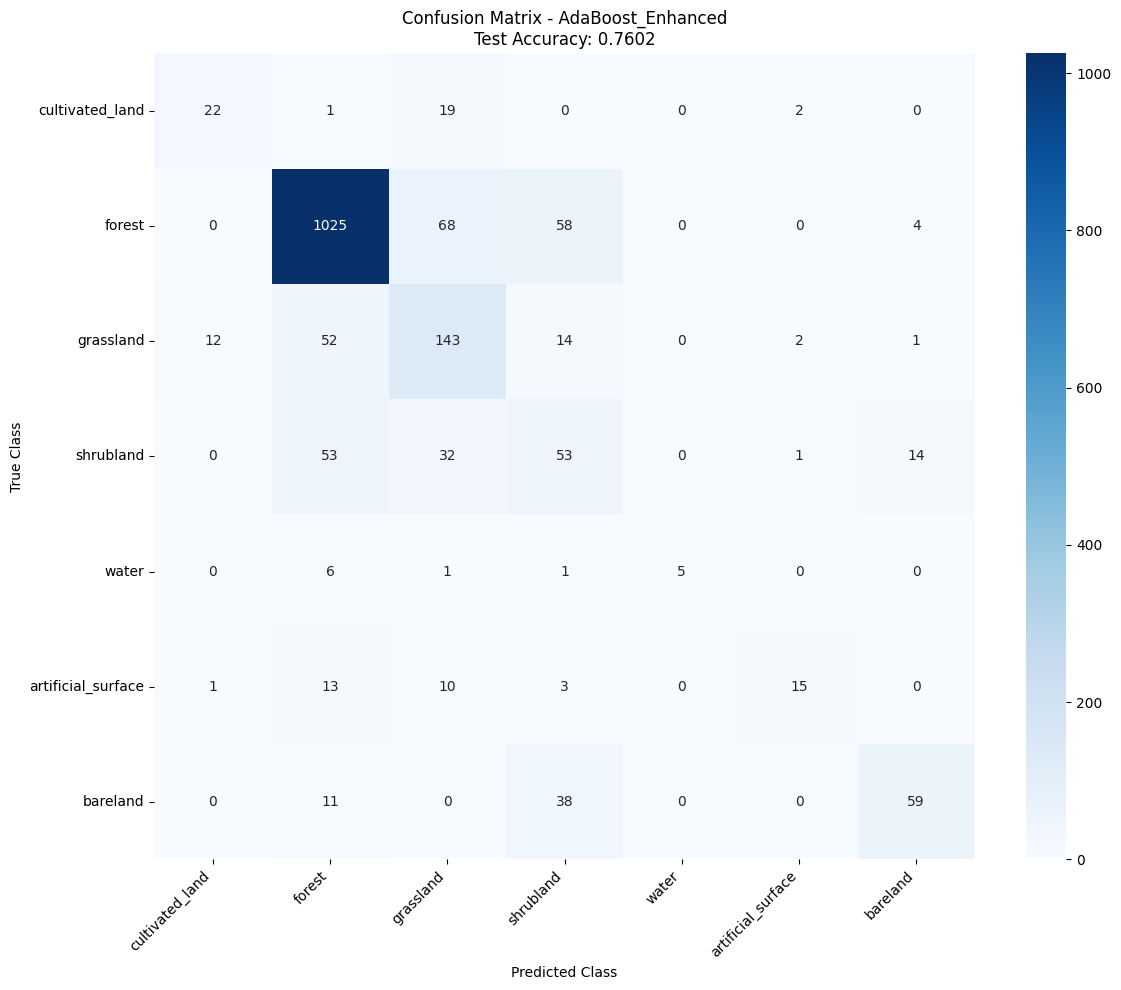


Detailed Classification Report - AdaBoost_Enhanced:
                    precision    recall  f1-score   support

   cultivated_land       0.63      0.50      0.56        44
            forest       0.88      0.89      0.89      1155
         grassland       0.52      0.64      0.58       224
         shrubland       0.32      0.35      0.33       153
             water       1.00      0.38      0.56        13
artificial_surface       0.75      0.36      0.48        42
          bareland       0.76      0.55      0.63       108

          accuracy                           0.76      1739
         macro avg       0.69      0.52      0.57      1739
      weighted avg       0.77      0.76      0.76      1739



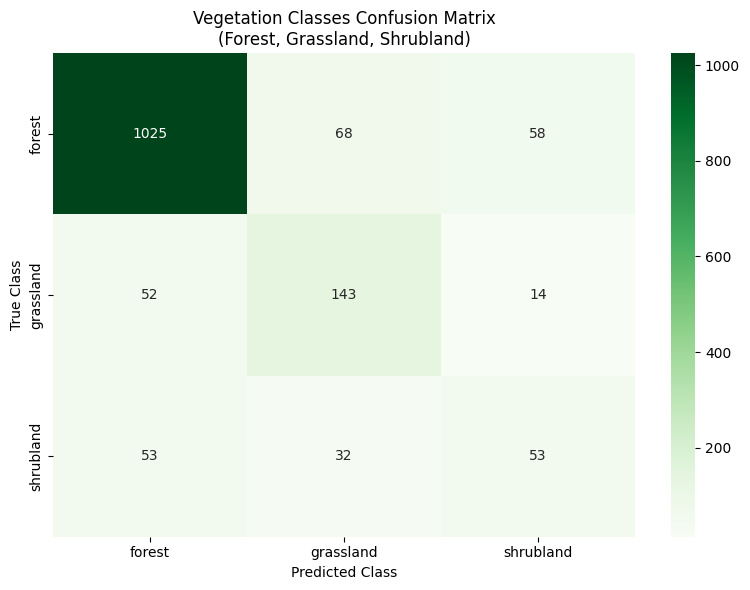

Vegetation classes accuracy: 0.7970
forest      : 0.891 recall (1025/1151)
grassland   : 0.684 recall (143/209)
shrubland   : 0.384 recall (53/138)

FINAL RESULTS:
Baseline (central pixels only): 71.88%
Enhanced model (AdaBoost_Enhanced): 76.02%
Improvement: +4.14 percentage points


In [5]:
# %% [markdown]
# ## Results Comparison

# %%
print("\n" + "=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)

best_model_name = max(results.keys(), key=lambda k: results[k]["test_accuracy"])

for model_name, result in results.items():
    marker = " ★ BEST" if model_name == best_model_name else ""
    print(f"{model_name:20s}: {result['test_accuracy']:.4f}{marker}")

best_result = results[best_model_name]
print(f"\nBest model: {best_model_name}")
print(
    f"Test accuracy improvement: {best_result['test_accuracy']:.4f} vs 0.7188 baseline"
)
print(
    f"Improvement: +{(best_result['test_accuracy'] - 0.7188) * 100:.2f} percentage points"
)

# %% [markdown]
# ## Detailed Analysis of Best Model

# %%
best_pred = best_result["test_pred"]

# Confusion matrix for best model
cm = confusion_matrix(y_test_flat, best_pred)

plt.figure(figsize=(12, 10))
class_names = [classes[i] for i in sorted(classes.keys())]
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title(
    f"Confusion Matrix - {best_model_name}\nTest Accuracy: {best_result['test_accuracy']:.4f}"
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print(f"\nDetailed Classification Report - {best_model_name}:")
print(classification_report(y_test_flat, best_pred, target_names=class_names))

# %% [markdown]
# ## Vegetation Class Analysis
# Focus on forest, grassland, and shrubland confusion

# %%
# Extract vegetation classes (forest=2, grassland=3, shrubland=4)
veg_classes = [2, 3, 4]
veg_names = [classes[i] for i in veg_classes]

# Filter predictions and true labels for vegetation classes only
veg_mask = np.isin(y_test_flat, veg_classes)
y_test_veg = y_test_flat[veg_mask]
y_pred_veg = best_pred[veg_mask]

# Create vegetation-only confusion matrix
veg_cm = confusion_matrix(y_test_veg, y_pred_veg, labels=veg_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    veg_cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=veg_names,
    yticklabels=veg_names,
)
plt.title("Vegetation Classes Confusion Matrix\n(Forest, Grassland, Shrubland)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()

# Calculate vegetation-specific accuracy
veg_accuracy = accuracy_score(y_test_veg, y_pred_veg)
print(f"Vegetation classes accuracy: {veg_accuracy:.4f}")

# Per-class accuracy for vegetation
for i, class_id in enumerate(veg_classes):
    class_name = classes[class_id]
    true_positives = veg_cm[i, i]
    total_true = veg_cm[i, :].sum()
    recall = true_positives / total_true if total_true > 0 else 0
    print(f"{class_name:12s}: {recall:.3f} recall ({true_positives}/{total_true})")

print("\nFINAL RESULTS:")
print("Baseline (central pixels only): 71.88%")
print(f"Enhanced model ({best_model_name}): {best_result['test_accuracy'] * 100:.2f}%")
print(
    f"Improvement: +{(best_result['test_accuracy'] - 0.7188) * 100:.2f} percentage points"
)